In [1]:
#Loading useful packages
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import os.path
import sys
import argparse
import warnings
warnings.filterwarnings('ignore')


#General purpose AI packages
from sklearn.cross_validation import train_test_split,KFold
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import ParameterGrid
from sklearn.gaussian_process import GaussianProcess

#Keras packages
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, ActivityRegularization
from keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from keras.optimizers import RMSprop
from keras import regularizers 

#Hyperparameter optimization
import hyperopt
from hyperopt import hp, STATUS_OK

C:\ProgramData\Anaconda3\envs\PY36\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [2]:
############## LOSSHISTORY CALLBACK CLASS ######################################
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

In [3]:
DATAFILE = os.path.join('data','data.csv')
TARGETFILE = os.path.join('data','target.csv')
OUTDIR = os.path.join('results')

In [4]:
############## PREPARING DATA ##################################################
dataset_trans = pd.read_table(os.path.join('data','dataset_trans.csv'),sep=',')
target = np.asarray(dataset_trans['Y'])
del dataset_trans['Y']
del dataset_trans['min_risk']
train = np.asarray(dataset_trans)
train_val_size = 0.8 #80% training+validation set and 20% test set
train_size = 0.7 #70% training set and 30% validation set
X_tr_val, X_te, Y_tr_val, Y_te = train_test_split(train, target, train_size=train_val_size, random_state=1)
X_tr, X_val, Y_tr, Y_val = train_test_split(X_tr_val, Y_tr_val, train_size=train_size, random_state=1)


In [5]:
def uniform_int(name, lower, upper):
    # `quniform` returns:
    # round(uniform(low, high) / q) * q
    return hp.quniform(name, lower, upper, q=1)

def loguniform_int(name, lower, upper):
    # Do not forget to make a logarithm for the
    # lower and upper bounds.
    return hp.qloguniform(name, np.log(lower), np.log(upper), q=1)

In [6]:
#def train_nn(X_tr,Y_tr,X_val,Y_val,params,verbose,save):
def train_nn(params):
    
    print('Testing: ', params)
    verbose = 0
    
    #Model callbacks
    filepath = os.path.join('results','weights.best.hdf5')
    mdlcheck = ModelCheckpoint(filepath, verbose=0, save_best_only=True)
    mdllosses = LossHistory()
    mdlstop = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')

    #Model fit
    n_epochs = 5000
    n_batch = int(params['fit_n_batch'])
    kf = KFold(n = np.shape(X_tr_val)[0], n_folds = 5)
    performance_cv = []
    #mdllosses_cv = []
    models = []
    
    i = 1
    for tr_idx, val_idx in kf:
        
        #Build NN
        model = Sequential()
        model.add(Dense(units=int(params['n_nodes_1']), input_dim=np.shape(X_tr)[1], activity_regularizer=regularizers.l2(params['regularization_1'])))
        model.add(Activation(params['activation_1']))
        model.add(Dropout(params['dropout_1']))
        model.add(Dense(units=int(params['n_nodes_2']),activity_regularizer=regularizers.l2(params['regularization_2'])))
        model.add(Activation(params['activation_2']))
        model.add(Dropout(params['dropout_2']))
        model.add(Dense(units=int(params['n_nodes_3']),activity_regularizer=regularizers.l2(params['regularization_3'])))
        model.add(Activation(params['activation_3']))
        model.add(Dense(units=1))
        opt = RMSprop(lr=params['opt_lr'], rho=params['opt_rho'], epsilon=params['opt_epsilon'], decay=params['opt_decay'])
        model.compile(loss=params['comp_loss'],optimizer=opt)
    
        print("Fold: ",i," of 5")
        i = i+1
        X_train, X_valid = X_tr_val[tr_idx], X_tr_val[val_idx]
        Y_train, Y_valid = Y_tr_val[tr_idx], Y_tr_val[val_idx]
        scaler = StandardScaler().fit(X_train)
        X_train = scaler.transform(X_train)
        X_valid = scaler.transform(X_valid)

        history = model.fit(X_train, Y_train, validation_data = (X_valid, Y_valid),  epochs = n_epochs, batch_size = n_batch, callbacks = [mdlstop,mdlcheck,mdllosses],verbose = verbose)
        
        #Recalling best weights and appending loss value and loss history
        model.load_weights(filepath)
        models.append(model)
        performance_cv.append(min(mdllosses.val_losses))
        #mdllosses_cv.append(mdllosses)
        
    #Calculating in-cv std 
    loss_std = np.std(performance_cv)
    
    print('Obtained loss: ', np.mean(performance_cv), ' (', loss_std, ')')
    #Return model and best performances
    return {'loss' : np.mean(performance_cv), 'status': STATUS_OK, 'model': models[np.argmin(performance_cv)], 'loss_std': loss_std}

In [7]:
#Defining the trial memory space
trials = hyperopt.Trials()

#Defining the hyperparameter space
parameter_space = {
    'n_nodes_1': uniform_int('n_nodes_1', 1, 1000),
    'regularization_1': 0,
    'dropout_1': hp.uniform('dropout_1', 0, 0.5),
    'activation_1': hp.choice('activation_1', ['relu','sigmoid','tanh']),
    'n_nodes_2': uniform_int('n_nodes_2', 1, 1000),
    'regularization_2': 0,
    'dropout_2': hp.uniform('dropout_2', 0, 0.5),
    'activation_2': hp.choice('activation_2', ['relu','sigmoid','tanh']),
    'n_nodes_3': uniform_int('n_nodes_3', 1, 1000),
    'regularization_3': 0,
    'activation_3': hp.choice('activation_3', ['relu','sigmoid','tanh']),
    'fit_n_batch' : uniform_int('fit_n_batch', 16, 128),
    'comp_loss' : 'mean_squared_error',
    'opt_lr' : 0.002,
    'opt_rho' : 0.9,
    'opt_epsilon' : 1e-08,
    'opt_decay' : 0.0}

#Defining the  tree
tpe = hyperopt.partial(
    hyperopt.tpe.suggest,

    # Sample 1000 candidate and select candidate that
    # has highest Expected Improvement (EI)
    n_EI_candidates=1000,
    
    # Use 20% of best observations to estimate next
    # set of parameters
    gamma=0.2,
    
    # First 20 trials are going to be random
    n_startup_jobs=20,
)

print('===== Training the NN... =====')
best = hyperopt.fmin(
    train_nn,
    trials=trials,
    space=parameter_space,

    # Set up TPE for hyperparameter optimization
    algo=tpe,

    # Maximum number of iterations. Basically it trains at
    # most 200 networks before choose the best one.
    max_evals=100,
)
print('==============================\n')


#And the winner is...
#trials.results <--- mi da la storia
print('======== Best NN... ========')
print('Validation loss: ', trials.best_trial['result']['loss'])
print('Best model hyperparameters: ', best)
model = trials.best_trial['result']['model']
#loss_history = trials.best_trial['result']['loss_history']
print('==============================\n')

===== Training the NN... =====
Testing:  {'activation_1': 'sigmoid', 'activation_2': 'sigmoid', 'activation_3': 'relu', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.1453706586924513, 'dropout_2': 0.23631224965565745, 'fit_n_batch': 84.0, 'n_nodes_1': 402.0, 'n_nodes_2': 399.0, 'n_nodes_3': 166.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regularization_1': 0, 'regularization_2': 0, 'regularization_3': 0}
Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  639.715305909  ( 177.682297298 )
Testing:  {'activation_1': 'sigmoid', 'activation_2': 'tanh', 'activation_3': 'tanh', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.29566059696561064, 'dropout_2': 0.2118677985956796, 'fit_n_batch': 50.0, 'n_nodes_1': 270.0, 'n_nodes_2': 976.0, 'n_nodes_3': 492.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regularization_1': 0, 'regularization_2': 0, 'regularization_3': 0}
Fold:  1  of 5
Fold:

Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  2326.64854585  ( 686.007073013 )
Testing:  {'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'relu', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.34986657790124565, 'dropout_2': 0.1428125630398706, 'fit_n_batch': 119.0, 'n_nodes_1': 335.0, 'n_nodes_2': 357.0, 'n_nodes_3': 156.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regularization_1': 0, 'regularization_2': 0, 'regularization_3': 0}
Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  564.784821267  ( 133.146588964 )
Testing:  {'activation_1': 'sigmoid', 'activation_2': 'tanh', 'activation_3': 'relu', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.44886673203909194, 'dropout_2': 0.4192447698111931, 'fit_n_batch': 70.0, 'n_nodes_1': 681.0, 'n_nodes_2': 216.0, 'n_nodes_3': 841.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regularization_

Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  459.459073175  ( 139.03938643 )
Testing:  {'activation_1': 'tanh', 'activation_2': 'relu', 'activation_3': 'tanh', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.00032796983405405933, 'dropout_2': 0.3098913262710165, 'fit_n_batch': 44.0, 'n_nodes_1': 533.0, 'n_nodes_2': 942.0, 'n_nodes_3': 813.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regularization_1': 0, 'regularization_2': 0, 'regularization_3': 0}
Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  639.459865464  ( 150.756957734 )
Testing:  {'activation_1': 'tanh', 'activation_2': 'sigmoid', 'activation_3': 'sigmoid', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.2830301659956269, 'dropout_2': 0.25669824429032195, 'fit_n_batch': 65.0, 'n_nodes_1': 80.0, 'n_nodes_2': 488.0, 'n_nodes_3': 301.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regularizati

Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  507.461898555  ( 103.945834979 )
Testing:  {'activation_1': 'relu', 'activation_2': 'tanh', 'activation_3': 'tanh', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.3192211448353836, 'dropout_2': 0.229328675795878, 'fit_n_batch': 64.0, 'n_nodes_1': 823.0, 'n_nodes_2': 585.0, 'n_nodes_3': 886.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regularization_1': 0, 'regularization_2': 0, 'regularization_3': 0}
Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  464.931956637  ( 136.583988863 )
Testing:  {'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'tanh', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.40798598392580754, 'dropout_2': 0.1746834755089621, 'fit_n_batch': 71.0, 'n_nodes_1': 911.0, 'n_nodes_2': 438.0, 'n_nodes_3': 336.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regula

Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  512.577293522  ( 130.108063414 )
Testing:  {'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'relu', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.3512713385330469, 'dropout_2': 0.15995734510258094, 'fit_n_batch': 115.0, 'n_nodes_1': 752.0, 'n_nodes_2': 466.0, 'n_nodes_3': 886.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regularization_1': 0, 'regularization_2': 0, 'regularization_3': 0}
Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  886.710982484  ( 113.094344872 )
Testing:  {'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'tanh', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.430405007062448, 'dropout_2': 0.26292392897946965, 'fit_n_batch': 29.0, 'n_nodes_1': 849.0, 'n_nodes_2': 512.0, 'n_nodes_3': 698.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regu

Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  489.309241822  ( 110.36780879 )
Testing:  {'activation_1': 'relu', 'activation_2': 'relu', 'activation_3': 'tanh', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.22886370237717057, 'dropout_2': 0.34642544094389777, 'fit_n_batch': 57.0, 'n_nodes_1': 375.0, 'n_nodes_2': 215.0, 'n_nodes_3': 899.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regularization_1': 0, 'regularization_2': 0, 'regularization_3': 0}
Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  614.856875427  ( 120.978942821 )
Testing:  {'activation_1': 'tanh', 'activation_2': 'sigmoid', 'activation_3': 'tanh', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.2499412851586949, 'dropout_2': 0.3692599295162913, 'fit_n_batch': 112.0, 'n_nodes_1': 873.0, 'n_nodes_2': 415.0, 'n_nodes_3': 759.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'r

Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  427.229793959  ( 137.157802038 )
Testing:  {'activation_1': 'relu', 'activation_2': 'sigmoid', 'activation_3': 'sigmoid', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.0631899098136493, 'dropout_2': 0.09724644707528943, 'fit_n_batch': 81.0, 'n_nodes_1': 531.0, 'n_nodes_2': 927.0, 'n_nodes_3': 187.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho': 0.9, 'regularization_1': 0, 'regularization_2': 0, 'regularization_3': 0}
Fold:  1  of 5
Fold:  2  of 5
Fold:  3  of 5
Fold:  4  of 5
Fold:  5  of 5
Obtained loss:  408.261525074  ( 121.700942803 )
Testing:  {'activation_1': 'relu', 'activation_2': 'sigmoid', 'activation_3': 'sigmoid', 'comp_loss': 'mean_squared_error', 'dropout_1': 0.06290598481894272, 'dropout_2': 0.09742114620661425, 'fit_n_batch': 81.0, 'n_nodes_1': 530.0, 'n_nodes_2': 928.0, 'n_nodes_3': 1.0, 'opt_decay': 0.0, 'opt_epsilon': 1e-08, 'opt_lr': 0.002, 'opt_rho':


 Score NN:  18852.7424806


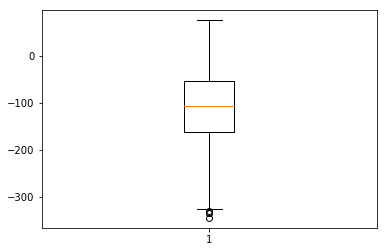

"\n#Histogram of the difference between actual values and estimates\nplt.hist(data_to_plot,bins=20)\nplt.show()\n\n#Plot of the actual values and estimates\nplt.plot(Y_te, marker='^')\nplt.plot(Y_NN, marker='o')\nplt.show()\n"

In [9]:
############## EVALUATING RESULTS  #############################################
Y_te = np.squeeze(Y_te)
Y_NN = np.squeeze(model.predict(X_te))

#MSE
print('\n Score NN: ',mean_squared_error(Y_NN,Y_te))


#Boxplot of the difference between actual values and estimates
data_to_plot = [Y_te-Y_NN]
plt.boxplot(data_to_plot)
plt.show()
"""
#Histogram of the difference between actual values and estimates
plt.hist(data_to_plot,bins=20)
plt.show()

#Plot of the actual values and estimates
plt.plot(Y_te, marker='^')
plt.plot(Y_NN, marker='o')
plt.show()
"""